# Conjugate Gradient Method

## 0. Initialize

In [1]:
using LinearAlgebra
using SparseArrays
using Random
using Plots
pyplot()

using ProgressMeter
using BenchmarkTools

## 1. Define functions

In [2]:
function my_CG(A, b, x₀, max_iter, ε)
    #initialize
    r = b - A(x₀)
    norm_r_new = norm(r)
    norm_r_old = norm_r_new
    p = copy(r)
    Ap = A(p)
    x = copy(x₀)
    norm_b = norm(b)
    
    #save residual norm
    history = zeros(max_iter)
    history[1] = norm_r_new / norm_b
    
    if norm_r_new < ε * norm_b
        return (x=x, history=history[1:1])
    end
    
    for k in 2:max_iter
        α = norm_r_old^2 / dot(p, Ap)
        x = x + α * p
        r = r - α * Ap
        norm_r_new = norm(r)
        history[k] = norm_r_new/norm_b
        
        if norm_r_new < ε * norm_b
            return (x=x, history=history[1:k])
        end
        
        β = norm_r_new^2 / norm_r_old^2
        p = r + β * p
        Ap = A(p)
        norm_r_old = norm_r_new
    end

    res = (x=x, history=history)
    return res 
end

function spmul(M, v)
    n = size(M, 1)
    Mv = zeros(n)
    for j in 1:n
        nz_begin = M.colptr[j]
        nz_end = M.colptr[j+1]-1
        for nz_idx in nz_begin:nz_end
            Mv[M.rowval[nz_idx]] += M.nzval[nz_idx] * v[j]
        end
    end
    return Mv 
end

#pivoting a matrix
function pivot!(A, b, n)
    #pivot
    tmp = zeros(n)
    for i in 1:n
        if A[i,i]==0
            j = argmax(A[:,i])
            tmp = A[i,:]
            A[i,:] = A[j,:]
            A[j,:] = tmp
            b[i], b[j] = b[j], b[i]
        end
    end
end

#LU factorization
function my_lu!(A)
    n = size(A, 1)
    L = zeros(n, n)
    pivot!(A, b, n)
    
    #forward elimination
    for k in 1:n-1
        for i in k+1:n
            L[i,k] = A[i,k] / A[k,k]
            for j in k+1:n
               A[i,j] = A[i,j] - L[i,k]*A[k,j]
            end
            A[i,k] = 0
        end
        L[k,k] = 1
    end
    L[n,n] = 1
    return L
end

function my_lu(A)
    A_copy = copy(A)
    L = my_lu!(A_copy)
    return L, A_copy
end

#forward elimination
function forward(L, b, n)
    y = zeros(n)
    y[1] = b[1]
    for k in 2:n
        y[k] = b[k] - dot(L[k,1:k-1], y[1:k-1])
    end
    return y
end

#backward substitution
function backward(U, y, n)
    x = zeros(n)
    x[n] = y[n] / U[n,n]
    for k in reverse(1:n-1)
        x[k] = (y[k] - dot(U[k,k+1:n], x[k+1:n])) / U[k,k]
    end
    return x
end

function lu_solver(A, b)
    n = size(b, 1)
    L, U =　my_lu(A)
    y = forward(L, b, n)
    x = backward(U, y, n)
    return x
end

lu_solver (generic function with 1 method)

## 2. Example

In [3]:
"""
    THIS IS A TEST RUN
"""
#create a linear equation system
Random.seed!(42)
n = 10
M = randn(n, n)
A = M' * M
x_true = rand(-5:5, n)
b = A*x_true

#LU
x_lu = lu_solver(Matrix(A), b)

#cojugate gradient method
x₀ = zeros(n)
max_iter = 10*n
ε = 1e-8
res_cg = my_CG(x->A*x, b, x₀, max_iter, ε);

 18.855748 seconds (8.01 k allocations: 153.766 MiB, 0.05% gc time)
relative error = 1.7497094381496745e-10
  2.735443 seconds (124.71 k allocations: 389.493 MiB, 11.08% gc time, 3.50% compilation time)
relative error = 0.002502428981890363


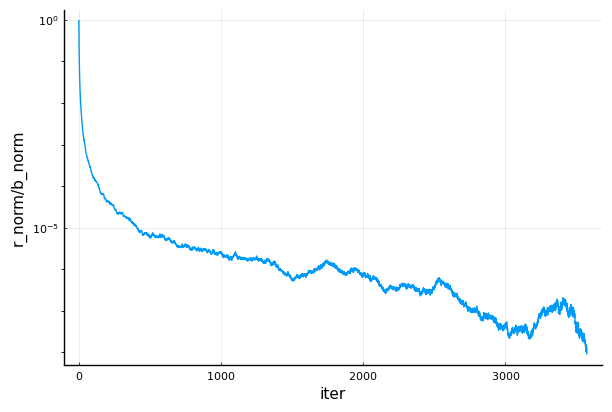

"/Users/kitanotomoya/Documents/julia/ML/ブログ/Conjugate-Gradient/fig1.png"

In [4]:
#create a linear equation system
Random.seed!(42)
n = 2000
M = randn(n, n)
A = M' * M
x_true = rand(-5:5, n)
b = A*x_true

#LU
@time x_lu = lu_solver(Matrix(A), b)
println("relative error = $(norm(x_lu - x_true)/norm(x_true))")

#cojugate gradient method
x₀ = zeros(n)
max_iter = 10*n
ε = 1e-8
@time res_cg = my_CG(x->A*x, b, x₀, max_iter, ε)
println("relative error = $(norm(res_cg.x - x_true)/norm(x_true))")

fig1 = plot(res_cg.history, label=false, xlabel="iter", ylabel="r_norm/b_norm", yscale=:log10)
savefig(fig1, "Conjugate-Gradient/fig1.png")

 19.074255 seconds (107.17 k allocations: 159.258 MiB, 0.05% gc time, 0.20% compilation time)
relative error = 4.306053477569902e-15
  0.158758 seconds (154.97 k allocations: 150.224 MiB, 12.79% gc time, 45.58% compilation time)
relative error = 1.0021751454243622e-8


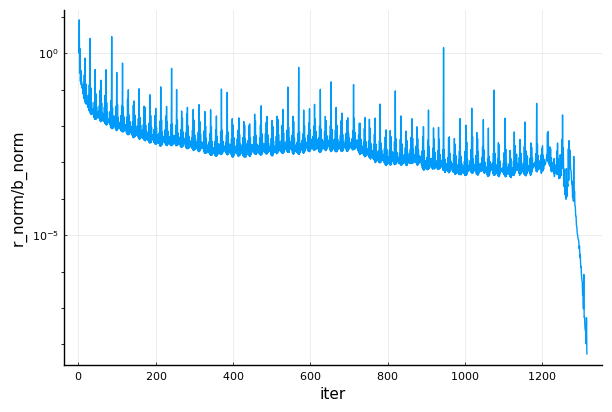

"/Users/kitanotomoya/Documents/julia/ML/ブログ/Conjugate-Gradient/fig2.png"

In [5]:
#create a linear equation system
Random.seed!(42)
n = 2000
A = spdiagm(-2=>ones(n-2), -1=>2*ones(n-1), 0=>-ones(n), 1=>2*ones(n-1), 2=>ones(n-2))
x_true = rand(-10:10, n)
b = A*x_true

#LU
@time x_lu = lu_solver(Matrix(A), b)
println("relative error = $(norm(x_lu - x_true)/norm(x_true))")

#cojugate gradient method
x₀ = zeros(n)
max_iter = 10*n
ε = 1e-8
@time res_cg = my_CG(x->spmul(A, x), b, x₀, max_iter, ε)
println("relative error = $(norm(res_cg.x - x_true)/norm(x_true))")

fig2 = plot(res_cg.history, label=false, xlabel="iter", ylabel="r_norm/b_norm", yscale=:log10)
savefig(fig2, "Conjugate-Gradient/fig2.png")